In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.interpolate import griddata
from osgeo import gdal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.interpolate import Rbf
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import os
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import zscore
from sklearn.inspection import partial_dependence
import numpy as np

C:\Users\laral\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Function to read multiple TIFF files and aggregate data
def read_multiple_tiff_data_gdal(file_paths):
    if not isinstance(file_paths, list):
        raise ValueError("file_paths should be a list of file paths.")
    
    all_x, all_y, all_z = [], [], []

    for file_path in file_paths:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"The file {file_path} was not found.")
        
        # Open the dataset
        dataset = gdal.Open(file_path)
        if dataset is None:
            raise RuntimeError(f"Unable to open {file_path}. Please check the file format and contents.")
        
        # Read the data and geotransform
        band = dataset.GetRasterBand(1)
        data = band.ReadAsArray()
        transform = dataset.GetGeoTransform()
        
        # Extract the grid coordinates
        cols = data.shape[1]
        rows = data.shape[0]
        
        x0, dx, _, y0, _, dy = transform
        x = np.linspace(x0, x0 + cols * dx, cols)
        y = np.linspace(y0, y0 + rows * dy, rows)
        
        # Mesh the grid coordinates and flatten them
        x, y = np.meshgrid(x, y)
        all_x.extend(x.flatten())
        all_y.extend(y.flatten())
        all_z.extend(data.flatten())
    
    return np.array(all_x), np.array(all_y), np.array(all_z)

In [3]:
best_params = {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

# D13C std

In [4]:
# Load your images (replace with the actual paths to your images)
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']


rad_file   = [r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site2a_rad_agg_mask.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site3b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4a_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6ab_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6c_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site7_rad_agg_mask.tif']


trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site2a_d13c_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site3b_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site4a_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site4b_d13c_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site6ab_d13c_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site6c_d13c_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_std\mask\site7_d13c_std_masked.tif' ]

In [5]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
rad_x, rad_y, rad_z = read_multiple_tiff_data_gdal(rad_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)



In [6]:
# Apply the mask based on the specified conditions
mask = (slope_z > 0.1) & (slope_z <= 50) & \
       (rad_z >= 1.9025386e-08) & (rad_z <= 2.5) 
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_rad = rad_z[mask]
filtered_traits = trait_z[mask]

Text(0, 0.5, 'Frequency')

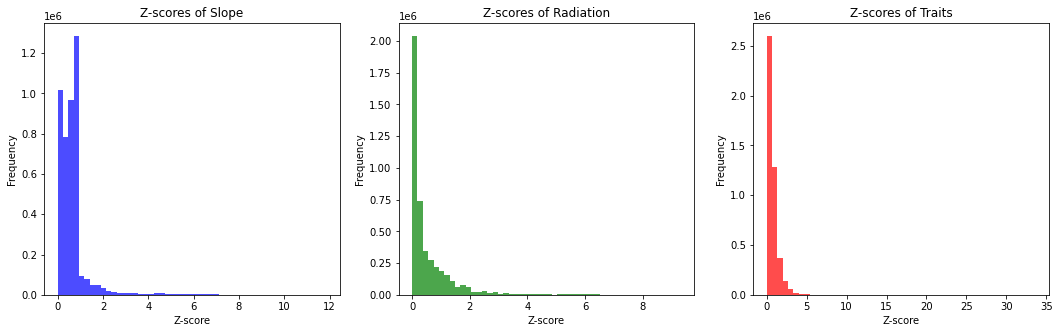

In [7]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'radiation': filtered_rad,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of Slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')

ax[1].hist(z_scores_df['radiation'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of Radiation')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')

In [8]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")



Number of rows after outlier removal: 2767388


In [9]:
# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'radiation']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

In [36]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=250
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T

Z_smooth = gaussian_filter(Z, sigma=250)

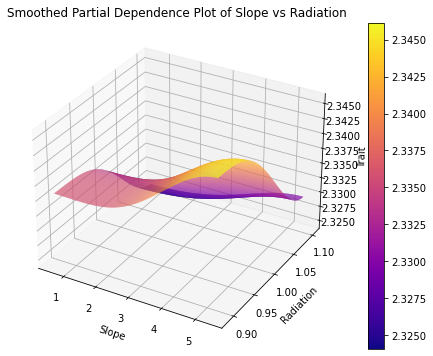

In [41]:
# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=80)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
#     edgecolor='r'

)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='Smoothed Partial Dependence Plot of Slope vs Radiation',
    xlabel='Slope',
    ylabel='Radiation',
    zlabel='Trait'
)
fig.colorbar(surf)
plt.show()

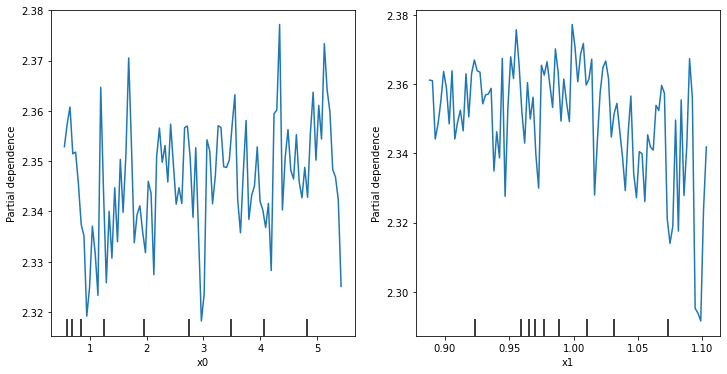

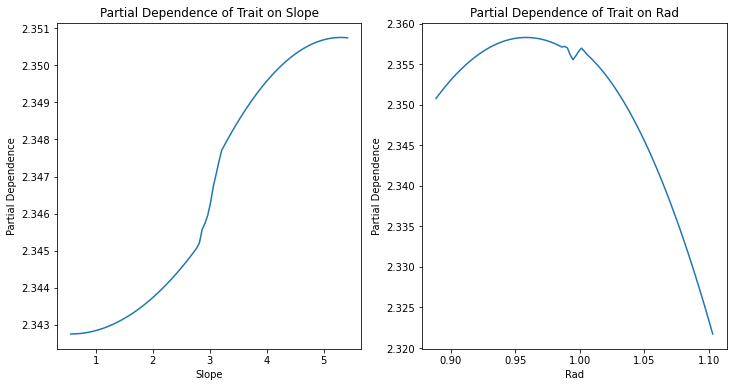

In [42]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on Slope')
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on Rad')
ax[1].set_xlabel('Rad')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# D13C ymax

In [43]:
# Load your images (replace with the actual paths to your images)
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']


rad_file   = [r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site2a_rad_agg_mask.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site3b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4a_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6ab_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6c_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site7_rad_agg_mask.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site2a_d13c_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site3b_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site4a_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site4b_d13c_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site6ab_d13c_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site6c_d13c_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d13c_ymax\masked\site7_d13c_ymax_masked.tif' ]

In [44]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
rad_x, rad_y, rad_z = read_multiple_tiff_data_gdal(rad_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)


# Apply the mask based on the specified conditions
mask = (slope_z > 0.1) & (slope_z <= 50) & \
       (rad_z >= 1.9025386e-08) & (rad_z <= 2.5) 
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_rad = rad_z[mask]
filtered_traits = trait_z[mask]

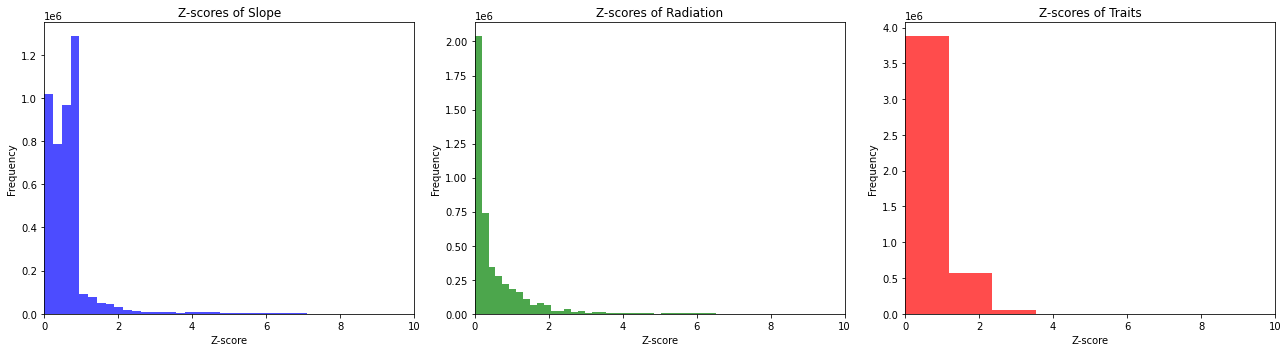

In [45]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'radiation': filtered_rad,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of Slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['radiation'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of Radiation')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [46]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'radiation']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 2939917


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

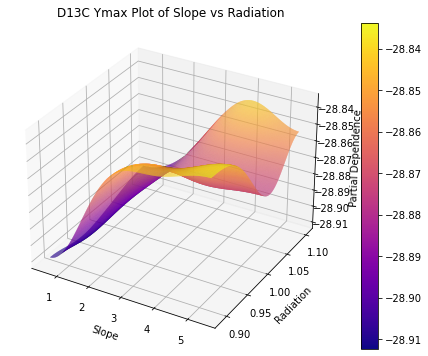

In [57]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=100)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='D13C Ymax Plot of Slope vs Radiation',
    xlabel='Slope',
    ylabel='Radiation',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

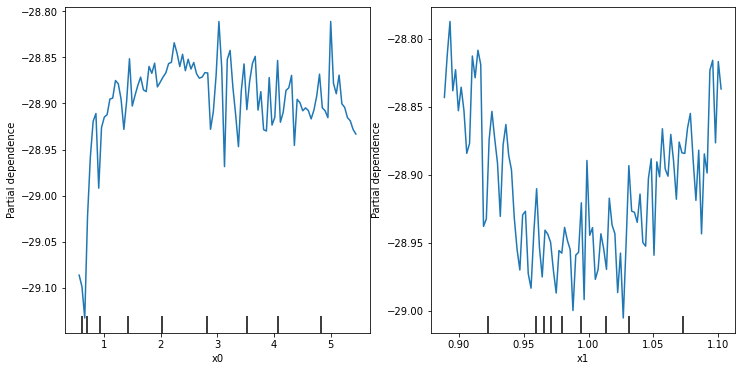

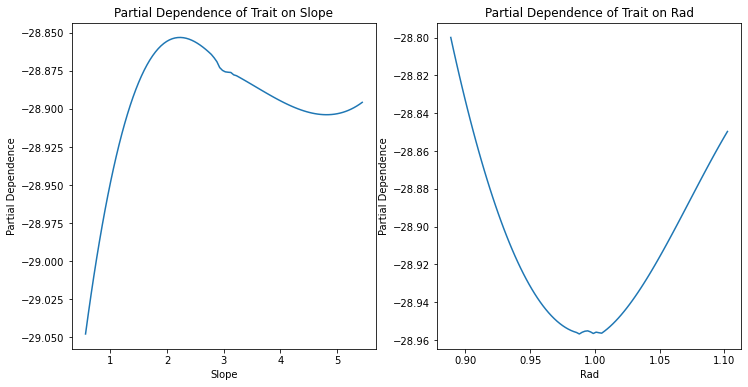

In [61]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=3)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=3)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on Slope')
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on Rad')
ax[1].set_xlabel('Rad')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# LA ymax

In [4]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']

slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site2a_la_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site3b_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site4a_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site4b_la_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site6ab_la_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site6c_la_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_ymax\mask\site7_la_ymax_masked.tif' ]

In [5]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (slope_z >= 0) & (slope_z <= 50)
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_slope = slope_z[mask]
filtered_traits = trait_z[mask]


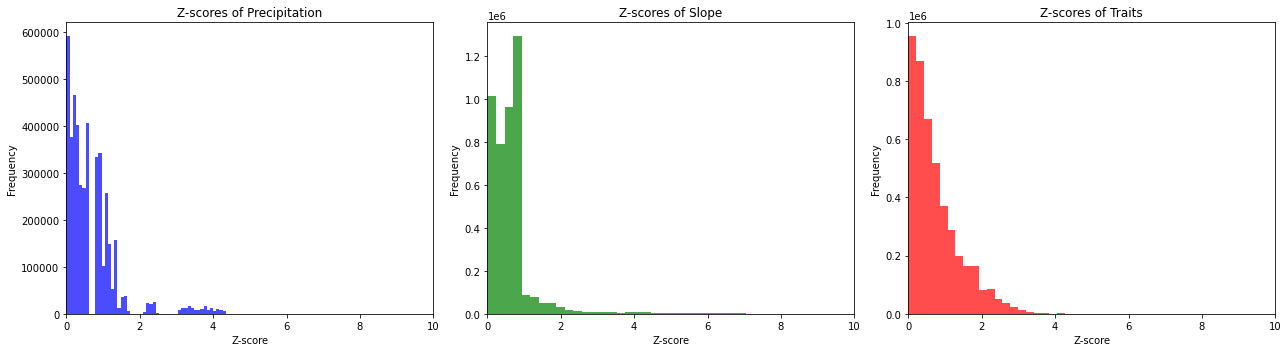

In [6]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'precipitation': filtered_precipitation,
    'slope': filtered_slope,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['precipitation'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of Precipitation')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['slope'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of Slope')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [7]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['precipitation', 'slope']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 2340023


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

In [23]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=1000
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# # Apply Gaussian filter to smooth the surface
# Z_smooth = gaussian_filter(Z, sigma=100)

# # Create an interactive 3D plot
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(
#     XX,
#     YY,
#     Z_smooth,
#     rstride=1,
#     cstride=1,
#     cmap='plasma',  # Change the colormap here
#     edgecolor='none'  # Remove the edge color
# )
# ax.view_init(elev=30, azim=-60)
# ax.set(
#     title='LA Ymax Plot of Precipitation vs Slope',
#     xlabel='Precipitation',
#     ylabel='Slope',
#     zlabel='Partial Dependence'
# )
# fig.colorbar(surf)
# plt.show()

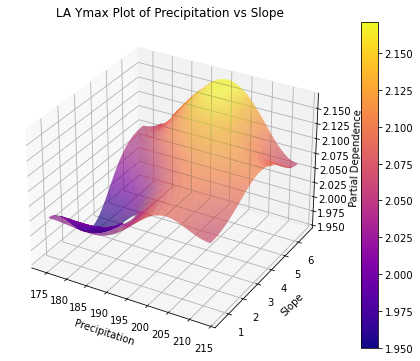

In [24]:
# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=200)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of Precipitation vs Slope',
    xlabel='Precipitation',
    ylabel='Slope',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

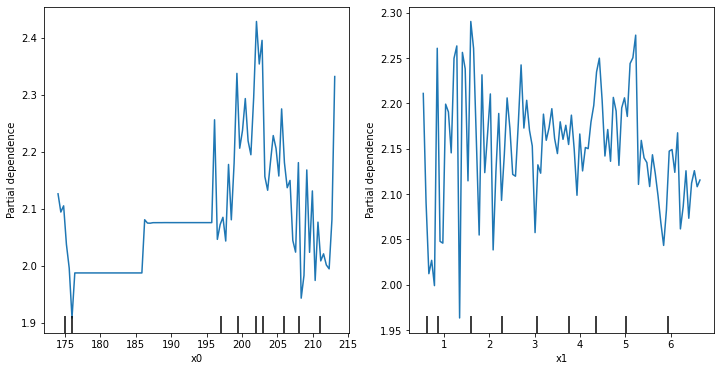

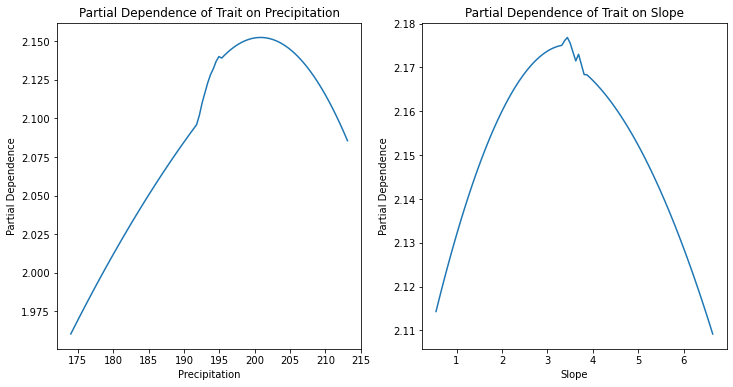

In [26]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on Precipitation')
ax[0].set_xlabel('Precipitation')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on Slope')
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# LA std

In [27]:
# Load your images (replace with the actual paths to your images)
precipitation_file  = [r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site2a_annual_precp_agg.tif',
                       r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site3b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4a_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site4b_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6ab_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site6c_annual_precp_agg.tif',
                      r'E:\wenqu\environmental_factors\3D_Plot\Annual_prep\aggregated\mask\site7_annual_precp_agg.tif']

slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site2a_la_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site3b_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site4a_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site4b_la_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site6ab_la_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site6c_la_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\la_std\mask\site7_la_std_masked.tif' ]

In [28]:
precipitation_x, precipitation_y, precipitation_z = read_multiple_tiff_data_gdal(precipitation_file)
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)


# Apply the mask based on the specified conditions
mask = (precipitation_z >= 154) & (precipitation_z <= 312) & \
       (slope_z >= 0) & (slope_z <= 50)
       

# Filter the data based on the mask
filtered_precipitation = precipitation_z[mask]
filtered_slope = slope_z[mask]
filtered_traits = trait_z[mask]

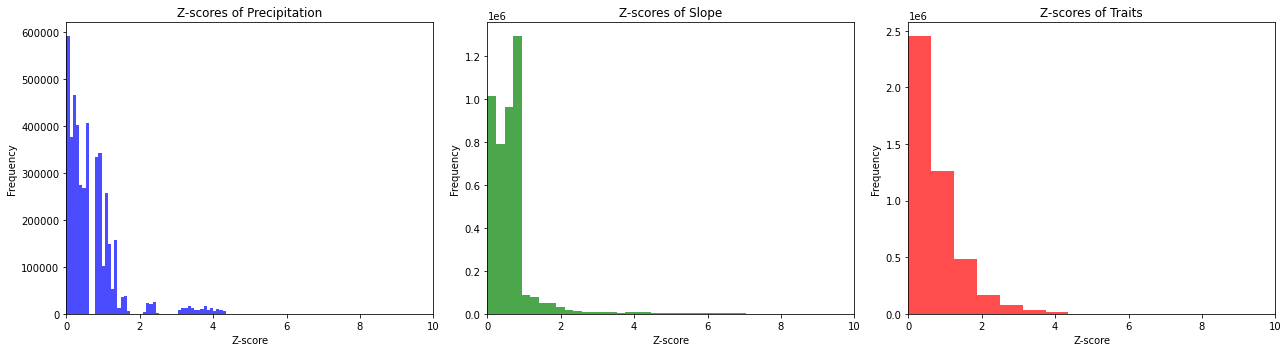

In [29]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'precipitation': filtered_precipitation,
    'slope': filtered_slope,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['precipitation'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of Precipitation')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['slope'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of Slope')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [30]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['precipitation', 'slope']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 2384382


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

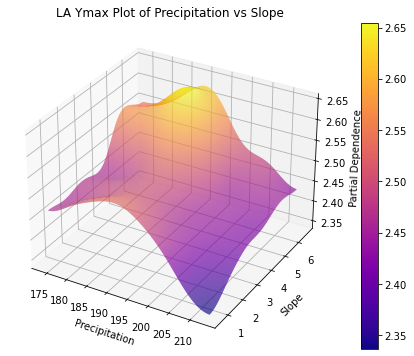

In [35]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=50)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of Precipitation vs Slope',
    xlabel='Precipitation',
    ylabel='Slope',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

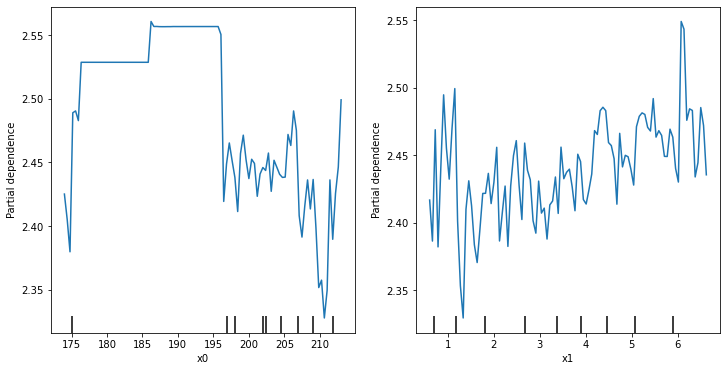

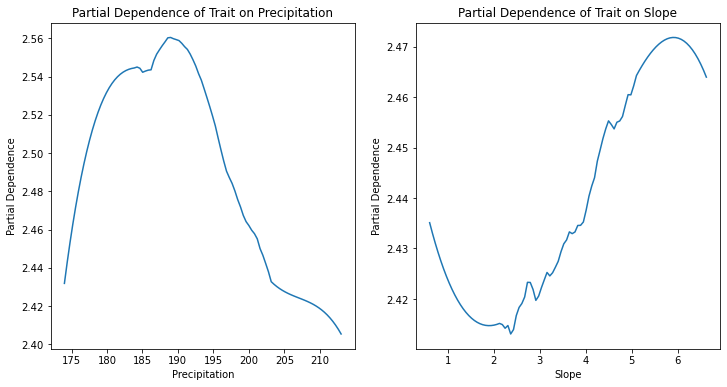

In [42]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=51, polyorder=3)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=51, polyorder=3)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on Precipitation')
ax[0].set_xlabel('Precipitation')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on Slope')
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# D15N Ymax

In [43]:


# Load your images (replace with the actual paths to your images)
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']


rad_file   = [r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site2a_rad_agg_mask.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site3b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4a_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6ab_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6c_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site7_rad_agg_mask.tif']


trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site2a_d15n_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site3b_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4a_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site4b_d15n_ymax_masked.tif',               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6ab_d15n_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site6c_d15n_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_ymax\mask\site7_d15n_ymax_masked.tif' ]

In [44]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
rad_x, rad_y, rad_z = read_multiple_tiff_data_gdal(rad_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

# Apply the mask based on the specified conditions
mask = (slope_z > 0) & (slope_z <= 50) & \
       (rad_z >= 0) & (rad_z <= 2.5) 
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_rad = rad_z[mask]
filtered_traits = trait_z[mask]


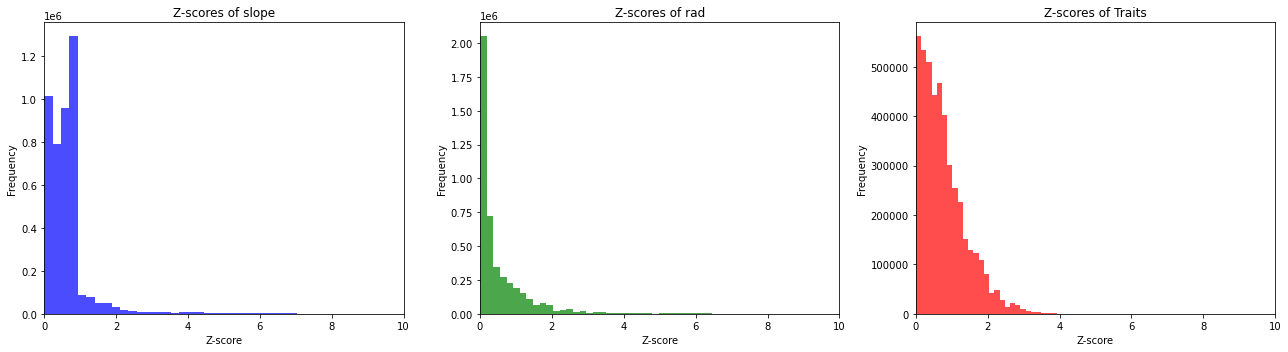

In [45]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'rad': filtered_rad,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['rad'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of rad')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [46]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'rad']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 2560924


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

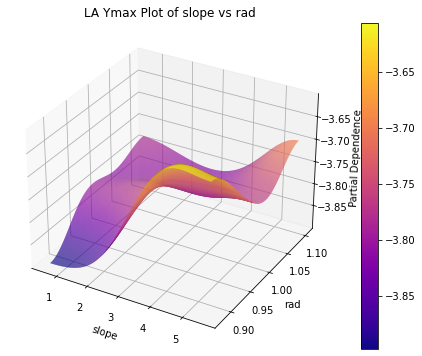

In [50]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=100)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs rad',
    xlabel='slope',
    ylabel='rad',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

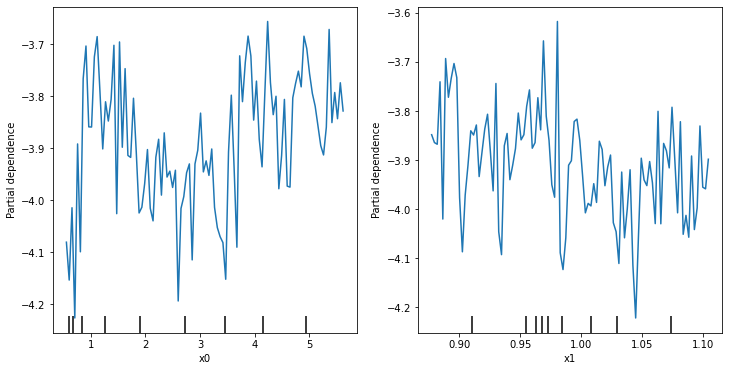

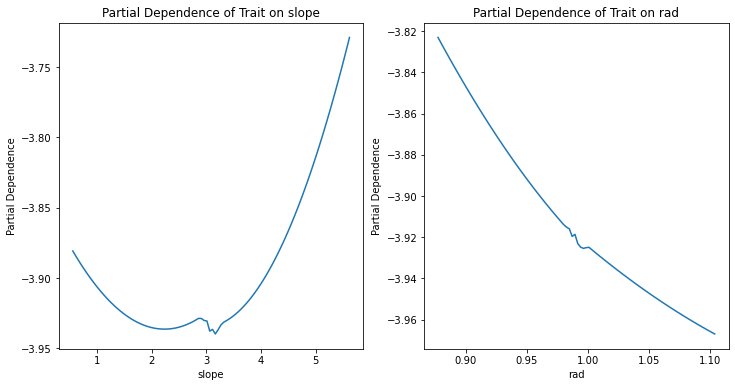

In [56]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on rad')
ax[1].set_xlabel('rad')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# D15N std

In [57]:

# Load your images (replace with the actual paths to your images)
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']


rad_file   = [r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site2a_rad_agg_mask.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site3b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4a_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site4b_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6ab_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site6c_rad_agg_mask.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\RAD\mask\site7_rad_agg_mask.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site2a_d15n_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site3b_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site4a_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site4b_d15n_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site6ab_d15n_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site6c_d15n_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\d15n_std\mask\site7_d15n_std_masked.tif' ]

In [58]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
rad_x, rad_y, rad_z = read_multiple_tiff_data_gdal(rad_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)
# Apply the mask based on the specified conditions
mask = (slope_z >= 0) & (slope_z <= 50) & \
       (rad_z >= 0) & (rad_z <= 2.5) 
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_rad = rad_z[mask]
filtered_traits = trait_z[mask]


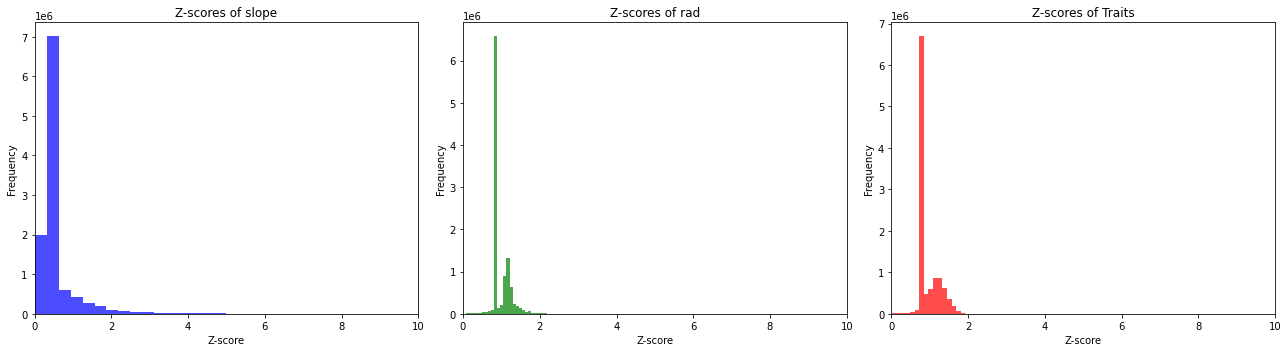

In [59]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'rad': filtered_rad,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['rad'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of rad')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [67]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 2

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'rad']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 10543718


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

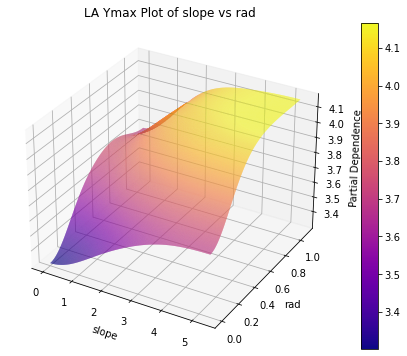

In [73]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=100)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs rad',
    xlabel='slope',
    ylabel='rad',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

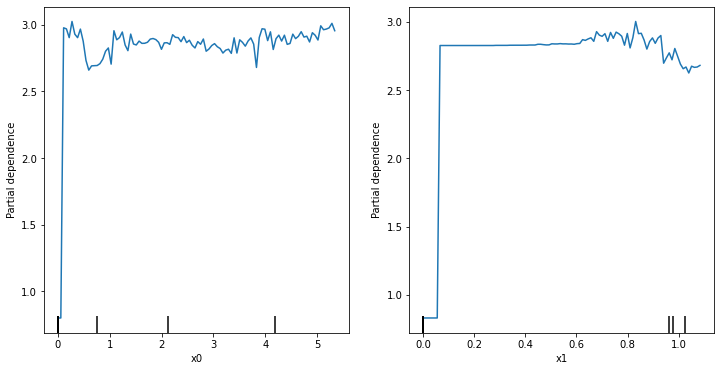

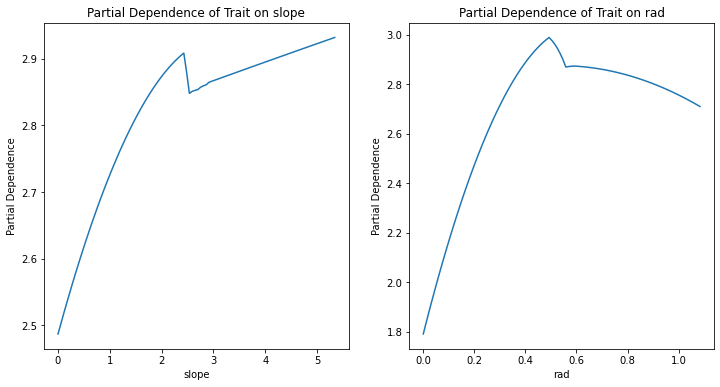

In [77]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on rad')
ax[1].set_xlabel('rad')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# LDMC ymax

In [4]:
# Load your images (replace with the actual paths to your images)
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site2a_ldmc_ymax_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site3b_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site4a_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site4b_ldmc_ymax_masked.tif',               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site6ab_ldmc_ymax_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site6c_ldmc_ymax_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_ymax\mask\site7_ldmc_ymax_masked.tif' ]

In [5]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

In [6]:
# Apply the mask based on the specified conditions
mask = (slope_z >= 0) & (slope_z <= 50) & \
       (temperature_z >= 105) & (temperature_z <= 156)
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]


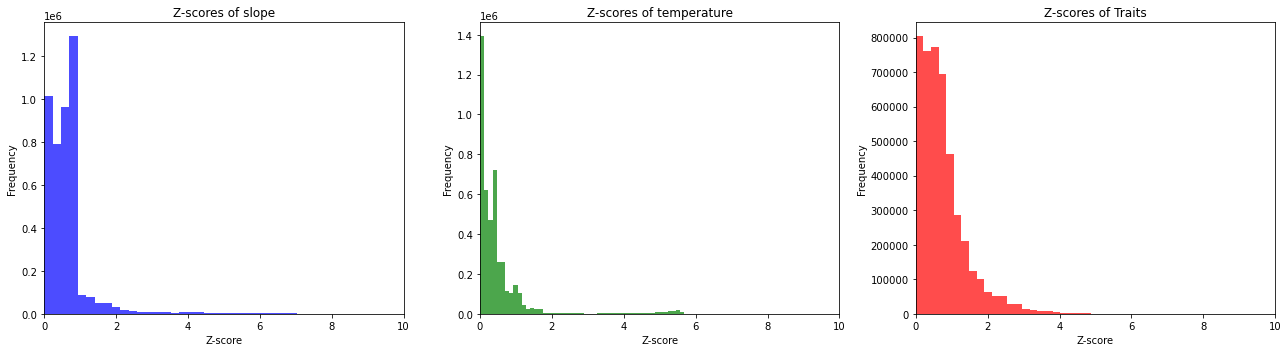

In [7]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'temperature': filtered_temperature,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['temperature'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of temperature')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [8]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 2

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'temperature']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 4074970


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

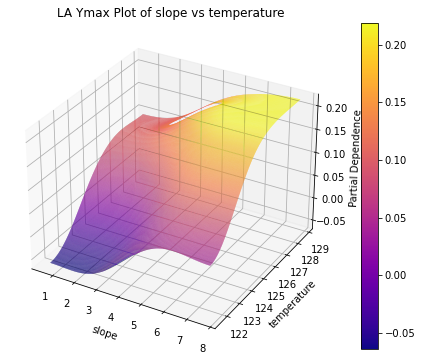

In [13]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=1000
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=200)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs temperature',
    xlabel='slope',
    ylabel='temperature',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

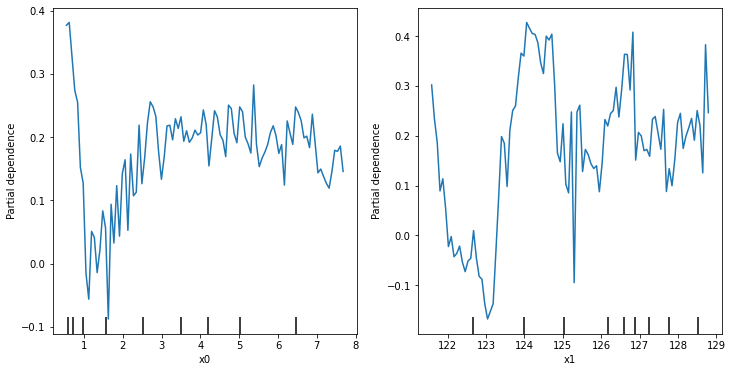

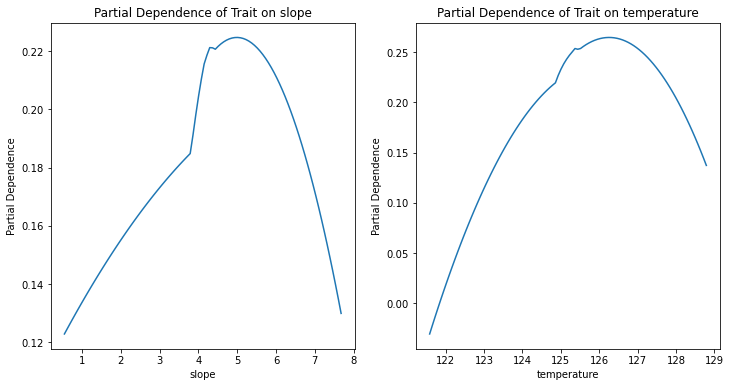

In [16]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on temperature')
ax[1].set_xlabel('temperature')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# LDMC std

In [17]:
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

temperature_file   = [r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site2a_swi_agg.tif',
                     r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site3b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4a_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site4b_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6ab_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site6c_swi_agg.tif',
                    r'E:\wenqu\environmental_factors\3D_Plot\SWI\agg\mask\site7_swi_agg.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site2a_ldmc_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site3b_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site4a_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site4b_ldmc_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site6ab_ldmc_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site6c_ldmc_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\ldmc_std\mask\site7_ldmc_std_masked.tif' ]

In [18]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
temperature_x, temperature_y, temperature_z = read_multiple_tiff_data_gdal(temperature_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

In [19]:
# Apply the mask based on the specified conditions
mask = (slope_z >= 0) & (slope_z <= 50) & \
       (temperature_z >= 105) & (temperature_z <= 156)
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_temperature = temperature_z[mask]
filtered_traits = trait_z[mask]


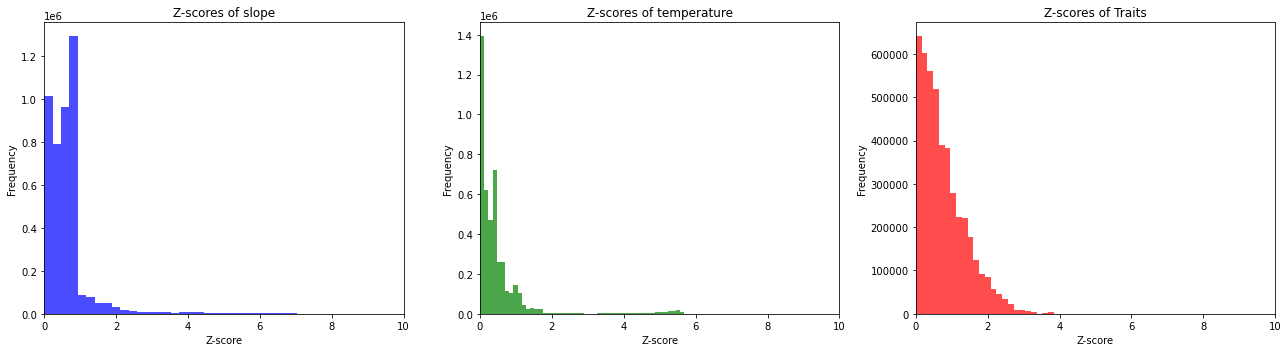

In [20]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'temperature': filtered_temperature,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['temperature'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of temperature')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [21]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 2

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'temperature']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 3991357


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

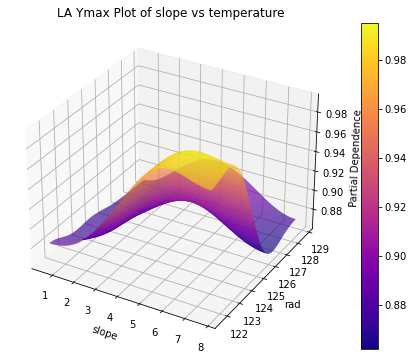

In [32]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=500
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=80)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs temperature',
    xlabel='slope',
    ylabel='rad',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

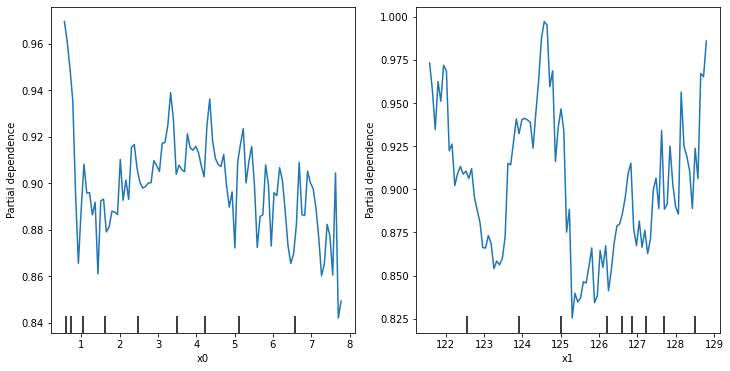

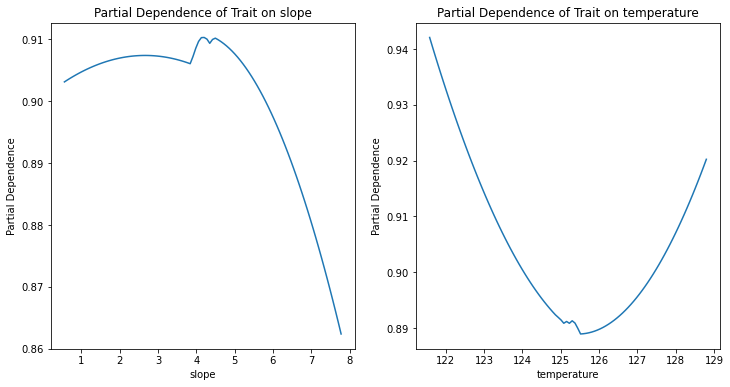

In [31]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=2)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=2)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on temperature')
ax[1].set_xlabel('temperature')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# SLA ymax


In [8]:
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

PET_file = [r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site2a_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site3b_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site4a_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site4b_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site6ab_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site6c_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site7_PET_agg_mask.tif']


trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site2a_sla_ymax_mask.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site3b_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site4a_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site4b_sla_ymax_mask.tif',               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site6ab_sla_ymax_mask.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site6c_sla_ymax_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_ymax\mask\site7_sla_ymax_mask.tif' ]

In [9]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
PET_x, PET_y, PET_z = read_multiple_tiff_data_gdal(PET_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

In [10]:
# Apply the mask based on the specified conditions
mask = (slope_z >= 0) & (slope_z <= 50) & \
       (PET_z >= 280) & (PET_z <= 589)
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_PET = PET_z[mask]
filtered_traits = trait_z[mask]


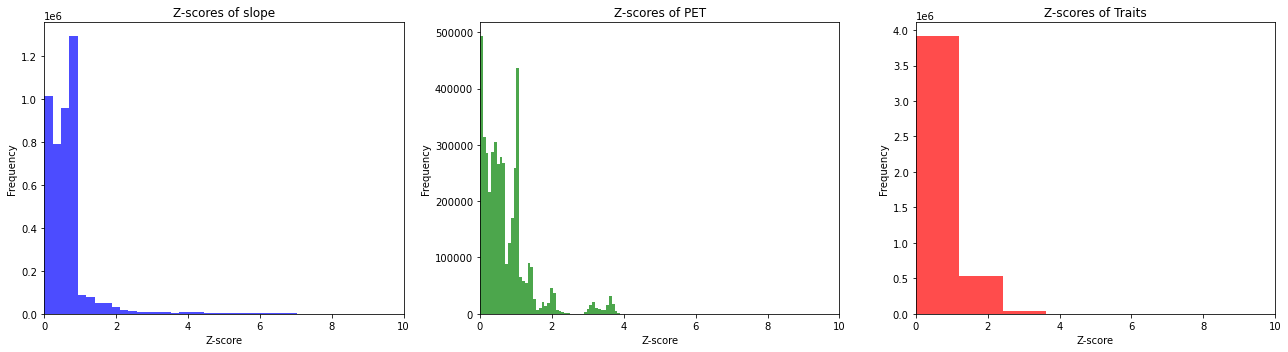

In [12]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'PET': filtered_PET,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['PET'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of PET')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [13]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'PET']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 2392333


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

C:\Users\laral\Anaconda3\envs\wenqu_gpu\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


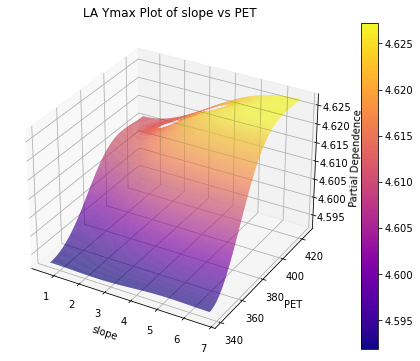

In [14]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=1000
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=250)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs PET',
    xlabel='slope',
    ylabel='PET',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

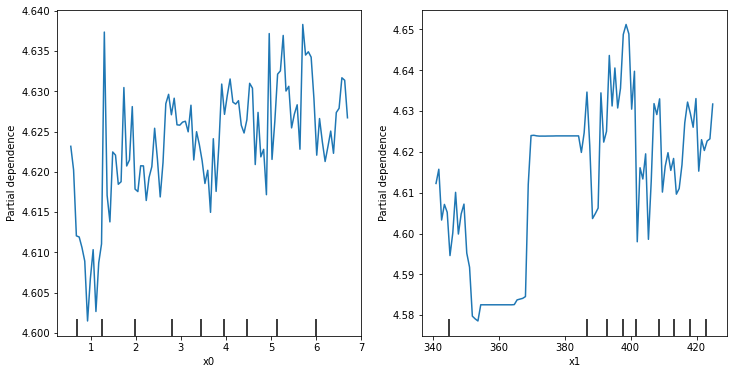

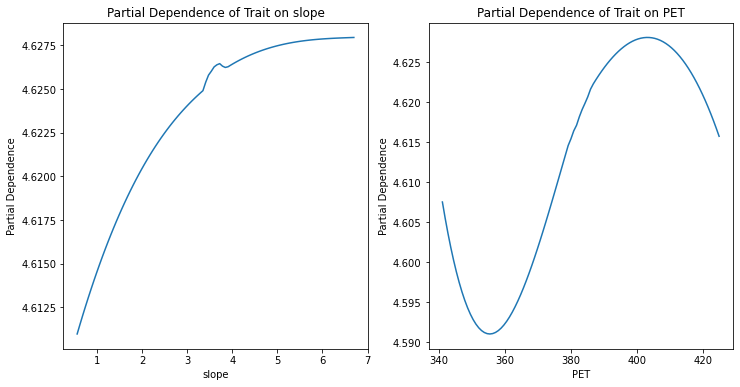

In [15]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=3)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=3)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on PET')
ax[1].set_xlabel('PET')
ax[1].set_ylabel('Partial Dependence')

plt.show()

# SLA std

In [16]:
slope_file  = [r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site2a_slope_agg_mask.tif',
               r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site3b_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4a_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site4bc_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6ab_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site6c_slope_agg_mask.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\slope\mask\site7_slope_agg_mask.tif']

PET_file = [r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site2a_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site3b_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site4a_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site4b_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site6ab_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site6c_PET_agg_mask.tif',
            r'E:\wenqu\environmental_factors\3D_Plot\PET\mask_3\site7_PET_agg_mask.tif']

trait_file  = [r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site2a_sla_std_masked.tif', 
               r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site3b_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site4a_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site4b_sla_std_masked.tif',
               
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site6ab_sla_std_masked.tif', 
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site6c_sla_std_masked.tif',
              r'E:\wenqu\environmental_factors\3D_Plot\trait_agg\sla_std\mask\site7_sla_std_masked.tif' ]

In [17]:
slope_x, slope_y, slope_z = read_multiple_tiff_data_gdal(slope_file)
PET_x, PET_y, PET_z = read_multiple_tiff_data_gdal(PET_file)
trait_x, trait_y, trait_z = read_multiple_tiff_data_gdal(trait_file)

In [18]:
# Apply the mask based on the specified conditions
mask = (slope_z >= 0) & (slope_z <= 50) & \
       (PET_z >= 280) & (PET_z <= 589)
       

# Filter the data based on the mask
filtered_slope = slope_z[mask]
filtered_PET = PET_z[mask]
filtered_traits = trait_z[mask]


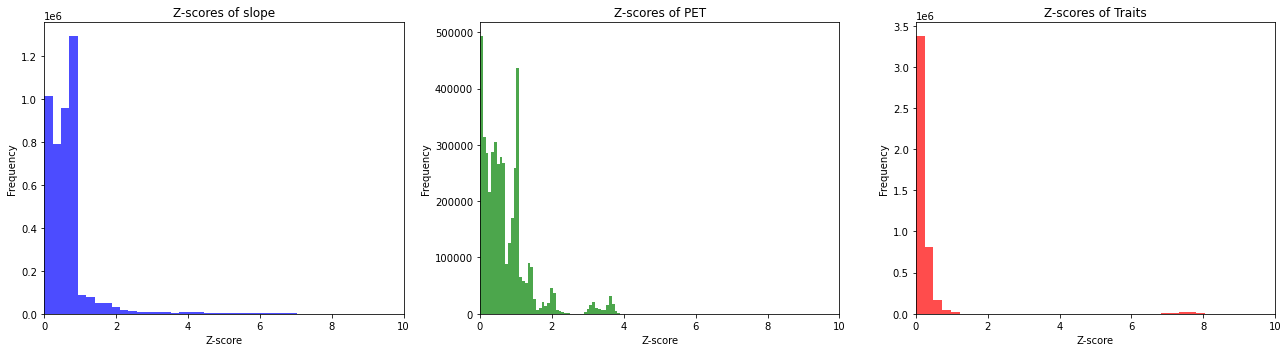

In [19]:
# Combine the features into a single DataFrame for easier outlier removal
data = pd.DataFrame({
    'slope': filtered_slope,
    'PET': filtered_PET,
    'traits': filtered_traits
})

# Calculate the Z-scores of each column
z_scores = np.abs(zscore(data))

# Convert the Z-scores to a DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=data.columns)

# Plot histograms of Z-scores for each column
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(z_scores_df['slope'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Z-scores of slope')
ax[0].set_xlabel('Z-score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[1].hist(z_scores_df['PET'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Z-scores of PET')
ax[1].set_xlabel('Z-score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

ax[2].hist(z_scores_df['traits'], bins=50, color='red', alpha=0.7)
ax[2].set_title('Z-scores of Traits')
ax[2].set_xlabel('Z-score')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 10)  # Set x-axis limits to 0 to 10

plt.tight_layout()
plt.show()

In [20]:
# Set a threshold for the Z-score to identify outliers (adjust based on histogram)
threshold = 1

# Remove rows where any feature has a Z-score above the threshold
data_clean = data[(z_scores < threshold).all(axis=1)]
# Print the number of rows after outlier removal
print(f"Number of rows after outlier removal: {data_clean.shape[0]}")


# Extract the cleaned features and target variable
x_data_clean = data_clean[['slope', 'PET']].to_numpy()
y_data_clean = data_clean['traits'].to_numpy()

# Create and fit a RandomForestRegressor model
model = RandomForestRegressor(**best_params)
model.fit(x_data_clean, y_data_clean)

Number of rows after outlier removal: 3031324


RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500)

C:\Users\laral\Anaconda3\envs\wenqu_gpu\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


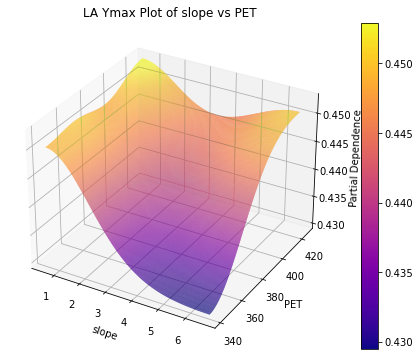

In [21]:
# Define the features to display in the 3D plot
features_to_display = (0, 1)  # Indices of 'slope' and 'radiation'

# Calculate partial dependence
pdp = partial_dependence(
    estimator=model,
    X=x_data_clean,
    features=features_to_display,
    kind='average',
    grid_resolution=1000
)

# Prepare data for the 3D plot
XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp['average'][0].T


# Apply Gaussian filter to smooth the surface
Z_smooth = gaussian_filter(Z, sigma=250)

# Create an interactive 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    XX,
    YY,
    Z_smooth,
    rstride=1,
    cstride=1,
    cmap='plasma',  # Change the colormap here
    edgecolor='none'  # Remove the edge color
)
ax.view_init(elev=30, azim=-60)
ax.set(
    title='LA Ymax Plot of slope vs PET',
    xlabel='slope',
    ylabel='PET',
    zlabel='Partial Dependence'
)
fig.colorbar(surf)
plt.show()

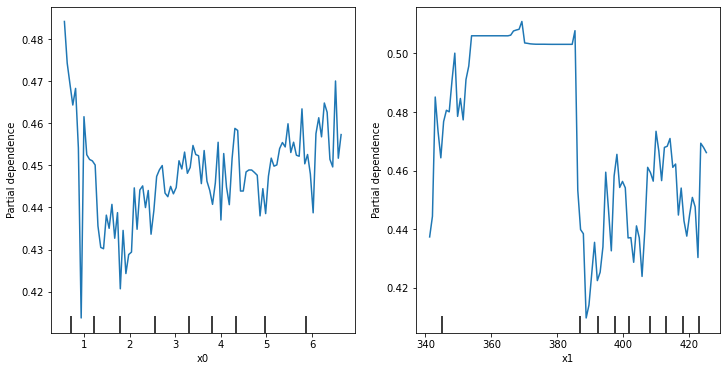

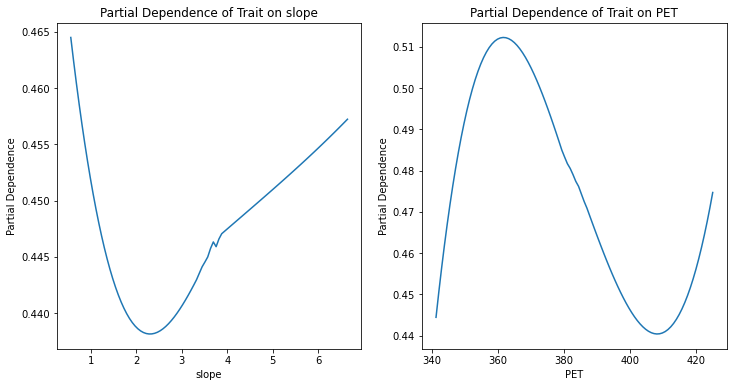

In [22]:
# Calculate partial dependence and get the display objects
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_precipitation = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[0], ax=ax[0], kind='average')
pdp_temperature = PartialDependenceDisplay.from_estimator(model, x_data_clean, features=[1], ax=ax[1], kind='average')

# Extract the x and y data from the display objects
precipitation_values = pdp_precipitation.lines_[0][0].get_xdata()
precipitation_partial_dependence = pdp_precipitation.lines_[0][0].get_ydata()
temperature_values = pdp_temperature.lines_[0][0].get_xdata()
temperature_partial_dependence = pdp_temperature.lines_[0][0].get_ydata()

# Apply Savitzky-Golay filter to smooth the curve
smoothed_precipitation = savgol_filter(precipitation_partial_dependence, window_length=91, polyorder=3)
smoothed_temperature = savgol_filter(temperature_partial_dependence, window_length=91, polyorder=3)

# Plot partial dependence with smoothed curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Precipitation
ax[0].plot(precipitation_values, smoothed_precipitation)
ax[0].set_title('Partial Dependence of Trait on slope')
ax[0].set_xlabel('slope')
ax[0].set_ylabel('Partial Dependence')

# Plot for Temperature
ax[1].plot(temperature_values, smoothed_temperature)
ax[1].set_title('Partial Dependence of Trait on PET')
ax[1].set_xlabel('PET')
ax[1].set_ylabel('Partial Dependence')

plt.show()